## Definitions

In [1]:
%matplotlib inline
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta, Adam, SGD, Nadam
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.wrappers.scikit_learn import KerasClassifier

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/My Drive/Colab Notebooks") # might have to change path to point to your Colab Notebooks folder

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Mounted at /content/gdrive


## Load and format data

Number of classes: 10
Example of handwritten digit with correlated noise: 



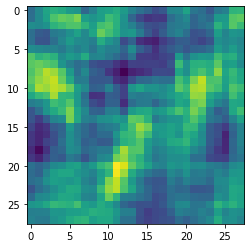

Class: 1

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


In [2]:
data = np.load('./MNIST_CorrNoise.npz')

x_train = data['x_train']
y_train = data['y_train']

num_cls = len(np.unique(y_train))
print('Number of classes: ' + str(num_cls))

print('Example of handwritten digit with correlated noise: \n')

k = 67
plt.imshow(np.squeeze(x_train[k,:,:]))
plt.show()
print('Class: '+str(y_train[k])+'\n')

# RESHAPE and normalize
x_train = np.expand_dims(x_train/255,axis=3)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_cls)

print('Shape of x_train: '+str(x_train.shape))
print('Shape of y_train: '+str(y_train.shape))

## Training

In [0]:

model_name='CNN' # To compare models, you can give them different names

pweight='./weights/weights_' + model_name  + '.hdf5'

if not os.path.exists('./weights'):
  os.mkdir('./weights')

## EXPLORE VALUES AND FIND A GOOD SET
b_size = 70 # batch size
val_split = 0.001 # percentage of samples used for validation (e.g. 0.5)
ep = 8 # number of epochs


x_train=np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')  # Zero padding








Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
average_pooling2d_2 (Average (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 175)        

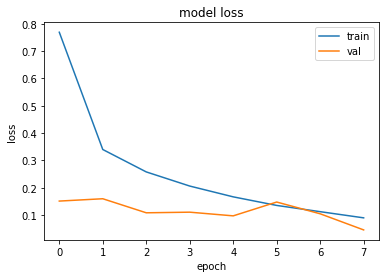

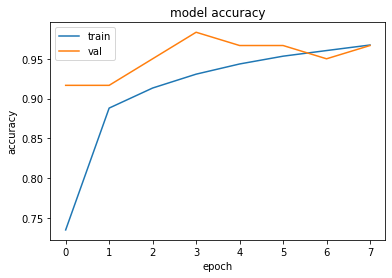

In [4]:

input_shape = x_train.shape[1:4] 

def create_model():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',padding="valid", input_shape=input_shape))
    model.add(AveragePooling2D(strides=2))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="valid",activation='relu'))
    model.add(AveragePooling2D(strides=2))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="valid",activation='relu'))
    
    
    model.add(Flatten())
    model.add(Dense(units=175, activation='relu'))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=10, activation = 'softmax'))
    model.compile(loss=categorical_crossentropy,
              optimizer=Nadam(), # explore other optimizers: Adam, SGD
              metrics=['accuracy'])
    model.summary()
    return model
model = KerasClassifier(build_fn=create_model, verbose=-1)

checkpointer = ModelCheckpoint(filepath=pweight, verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpointer, earlystop] # explore adding other callbacks such as ReduceLROnPlateau, EarlyStopping

history=model.fit(x_train, y_train,
                        epochs=ep,
                        batch_size=b_size,
                        verbose=1,
                        shuffle=True,
                        validation_split = val_split,
                        callbacks=callbacks_list)

print('CNN weights saved in ' + pweight)

# Plot loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot accuracy vs epochs
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




## Make predictions in test set

In [5]:
from keras.models import load_model

## LOAD DATA
data = np.load('./MNIST_CorrNoise.npz')

x_test = data['x_test']
y_test = data['y_test'] 

num_cls = len(np.unique(y_test))
print('Number of classes: ' + str(num_cls))

# RESHAPE and standarize
x_test = np.expand_dims(x_test/255,axis=3)
x_test=np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
print('Shape of x_train: '+str(x_test.shape)+'\n')

## Define model parameters
model_name='CNN' # To compare models, you can give them different names
pweight='./weights/weights_' + model_name  + '.hdf5'

model = load_model(pweight)
y_pred = model.predict_classes(x_test)

Acc_pred = sum(y_pred == y_test)/len(y_test)

print('Accuracy in test set is: '+str(Acc_pred))


Number of classes: 10
Shape of x_train: (10000, 32, 32, 1)

Accuracy in test set is: 0.9102


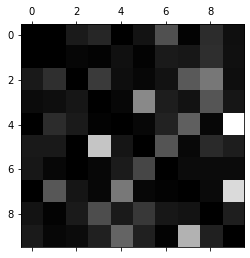

In [6]:

from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_test,y_pred)
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sums
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

Zero padding. From 28x28x1 to 32x32x1